In [1]:
from characters_real_names import *

import re
import spacy
from spacy.tokens import Span

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from community import community_louvain as louvain
from netwulf import visualize

nlp = spacy.load("en_core_web_sm")

# Used to get the gender and distinct people with same family noun. 

def get_person_title(span):
    if span.label_ == "PERSON" and span.start != 0:
        prev_token = span.doc[span.start - 1]
        if prev_token.text in ("Mr", "Mr.", "Mrs", "Mrs."):
            return prev_token.text + " "
    return ""

Span.set_extension("person_title", getter=get_person_title, force=True)

book = open("../Homework 1/Harry Potter and the Sorcerer.txt").read()

book_chapters = re.split(r'CHAPTER [\w+]+', book, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("THE END")[0]


In [2]:
docs = nlp(''.join(book_chapters))
all_sentences = [sent.text.strip() for sent in docs.sents]

In [3]:
from tqdm import tqdm
all_characters_per_sentence = list()
all_sentences_modified = list()

# 7267 iterations
for i,sentence in tqdm(enumerate(all_sentences)):
    doc = nlp(sentence)
    entities = [dict(title=ent._.person_title,name=ent.text,position=(ent.start,ent.end)) for ent in doc.ents if ent.label_ == "PERSON"]
    all_characters_per_sentence.append(set())
    all_sentences_modified.append(sentence)

    for entity in entities:
        full_name = (entity.get('title') + entity.get('name')).strip()
        name_underscore = "_".join(entity.get('name').split(" "))
        if name_underscore in all_real_names.keys():
            all_characters_per_sentence[i].add(name_underscore)
            continue
        for real,check in all_real_names.items():
            if full_name in check: 
                real_underscore = "_".join(real.split(" "))
                all_sentences_modified[i] = re.sub(full_name, real_underscore, all_sentences_modified[i])
                all_characters_per_sentence[i].add(real_underscore)


7275it [00:58, 124.42it/s]


In [4]:
all_characters_global = set()
for characters in all_characters_per_sentence:
    for character in characters:
        all_characters_global.add(character)

In [5]:
all_characters_global

{'Aberforth_Dumbledore',
 'Adalbert_Waffling',
 'Albus_Dumbledore',
 'Alicia_Spinnet',
 'Angelina_Johnson',
 'Arabella_Figg',
 'Argus_Filch',
 'Auntie_Marge',
 'Bane',
 'Bill_Weasley',
 'Charlie_Weasley',
 'Dean_Thomas',
 'Dedalus_Diggle',
 'Doris_Crockford',
 'Draco_Malfoy',
 'Dudley_Dursley',
 'Dursleys_Family',
 'Filius_Flitwick',
 'Fred_Weasley',
 'Garrick_Ollivander',
 'George_Weasley',
 'Ginny_Weasley',
 'Gordon',
 'Gregory_Goyle',
 'Hannah_Abbott',
 'Harry_Potter',
 'Hedwig',
 'Helga_Hufflepuff',
 'Hermione_Granger',
 'Irma_Pince',
 'James_Potter',
 'Katie_Bell',
 'Lee_Jordan',
 'Lily_Potter',
 'Malcolm',
 'Malfoys_Family',
 'Marcus_Flint',
 'Minerva_McGonagall',
 'Molly_Weasley',
 'Neville_Longbottom',
 'Nicholas_de_Mimsy',
 'Nicolas_Flamel',
 'Norbert',
 'Norris',
 'Oliver_Wood',
 'Percy_Weasley',
 'Petunia_Dursley',
 'Piers_Polkiss',
 'Poppy_Pomfrey',
 'Quentin_Trimble',
 'Quirinus_Quirrell',
 'Ron_Weasley',
 'Rubeus_Hagrid',
 'Salazar_Slytherin',
 'Seamus_Finnigan',
 'Severu

In [6]:
# Graph filling by sentence
graph = nx.Graph()

for characters in all_characters_per_sentence:
    graph.add_nodes_from(characters)
    if len(characters) < 2 : continue
    unique = list(characters)
    for idx in range(len(unique)-1):
        edge = graph.get_edge_data(unique[idx], unique[idx-1])
        if edge is not None : graph[unique[idx]][unique[idx-1]]['weight'] += 1
        else : graph.add_edge(unique[idx], unique[idx-1], weight=1)



In [7]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

# Use mean partition of 100 partitions to smooth
boot_partitions = {}
for _ in tqdm(range(100)): 
    part = louvain.best_partition(graph)
    for k,v in part.items():
        if k in boot_partitions: boot_partitions[k].append(v)
        else: boot_partitions[k] = [v]

partition = {}
for k,v in boot_partitions.items(): partition[k] = round(sum(v) / len(v))

100%|██████████| 100/100 [00:00<00:00, 227.88it/s]


In [8]:
partition
part_clean = {}
for v,k in partition.items():
    if k not in part_clean:
        part_clean[k] = [v]
    else: part_clean[k].append(v)
part_clean

{0: ['Petunia_Dursley',
  'Vernon_Dursley',
  'Dudley_Dursley',
  'Dursleys_Family',
  'Auntie_Marge',
  'Arabella_Figg',
  'Piers_Polkiss',
  'Malcolm',
  'Gordon',
  'Hedwig'],
 1: ['Lily_Potter', 'Dedalus_Diggle', 'James_Potter', 'Doris_Crockford'],
 2: ['Harry_Potter',
  'Minerva_McGonagall',
  'Aberforth_Dumbledore',
  'Poppy_Pomfrey',
  'Rubeus_Hagrid',
  'Sirius_Black',
  'Tom_Riddle',
  'Quirinus_Quirrell',
  'Garrick_Ollivander',
  'Ginny_Weasley',
  'Ron_Weasley',
  'Nicolas_Flamel',
  'Hermione_Granger',
  'Seamus_Finnigan',
  'Neville_Longbottom',
  'Nicholas_de_Mimsy',
  'Severus_Snape',
  'Argus_Filch',
  'Norris',
  'Filius_Flitwick',
  'Dean_Thomas',
  'Marcus_Flint',
  'Weasley_Family',
  'Irma_Pince',
  'Bane'],
 3: ['Albus_Dumbledore'],
 4: ['Adalbert_Waffling'],
 5: ['Quentin_Trimble'],
 6: ['Helga_Hufflepuff',
  'Salazar_Slytherin',
  'Fred_Weasley',
  'George_Weasley',
  'Vincent_Crabbe',
  'Gregory_Goyle',
  'Draco_Malfoy',
  'Hannah_Abbott',
  'Susan_Bones',
  '

In [9]:
from gensim.parsing.preprocessing import preprocess_string

from string import punctuation
from gensim.parsing.preprocessing import strip_tags     
from gensim.parsing.preprocessing import strip_short      
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum

CUSTOM_FILTERS = [lambda x: strip_short(x.lower(), 1), strip_multiple_whitespaces, strip_tags, strip_non_alphanum]

all_sentences_preprocessed = []
punctuation_to_remove = punctuation.replace("_", "")
for sent in tqdm(all_sentences):
    sent = sent.translate(str.maketrans('', '', punctuation_to_remove))
    parsed_line = preprocess_string(sent, CUSTOM_FILTERS)
    all_sentences_preprocessed.append(parsed_line)

100%|██████████| 7275/7275 [00:00<00:00, 51010.41it/s]


In [16]:
import gensim

# DEFINE MODEL
model = gensim.models.Word2Vec(size=100, window = 4,
                               min_count=1, alpha = 0.01)

# BUILD VOCABULARY
model.build_vocab(all_sentences_preprocessed)

# AND TRAIN THE MODEL
iterations = range(10)
for i in iterations:
    model.train(all_sentences_preprocessed, total_examples=model.corpus_count, compute_loss = True, 
                epochs = 100)
    
# GET THE VOCABULARY FROM THE MODEL
vocabulary = list(model.wv.vocab)
print(f"Vocabulary size :: {len(vocabulary)}")

# GET THE WORD EMBEDDING VECTORS
embedding_vectors = model[model.wv.vocab]

Vocabulary size :: 6035


In [17]:
person_set_processed = [s for s in all_real_names if s.lower() in vocabulary]
person_set_vocab = [s.lower() for s in person_set_processed]
embedding_vectors_caracters=model[person_set_vocab]
#person_set_vocab

In [18]:
len(person_set_vocab)

16

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# TRANSFORM THE EMBEDDING USING T-SNE INTO 2D
V_tranform = TSNE(n_components=2).fit_transform(embedding_vectors_caracters)

ModuleNotFoundError: No module named 'sklearn'

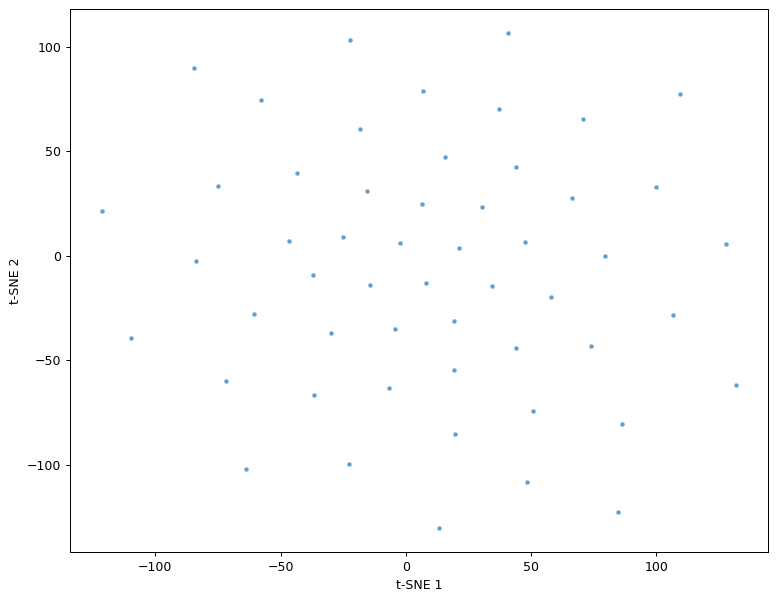

In [16]:
# PLOT THE PROJECTION
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=50, lw=0, alpha=0.7, 
                 edgecolor='k')
# for i, (x,y) in enumerate(V_tranform):
#     plt.text(x,y, vocabulary[i], 
#                 fontsize = 4, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()